In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [79]:
import networkx as nx # networkx的版本 >= 2.5
import matplotlib.pyplot as plt
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

# 将一个图形分割成两个有重合的分离顶点子图
def NaiveLGP(g, k):
    E = list(g.edges)
    E = [(min([u, v]),max([u, v])) for (u, v) in E]
    E.sort(key=lambda tup:tup[0])
    V = list(g.nodes)
    V.sort()

    counter = 1
    while True:
        num_nodes = counter
        nodes_combo = list(combinations(V, num_nodes))
        # 找有效的分离顶点
        for p in nodes_combo:
            V1 = [x for x in V if x not in p]
            E1 = [e for e in g.edges if e not in g.edges(p)]
            G1 = nx.Graph()
            G1.add_nodes_from(V1)
            G1.add_edges_from(E1)
            S = [G1.subgraph(c).copy() for c in nx.connected_components(G1)]
            if len(S) == 2:
                # 将分离顶点加入不相连的子图中
                V_S0 = list(S[0].nodes)
                E_S0 = list(S[0].edges)   
                V_S1 = list(S[1].nodes)
                E_S1 = list(S[1].edges)
                for (u, v) in g.edges(p):
                    if u in V_S0 or v in V_S0:
                        S[0].add_edges_from([(u, v)])
                    if u in V_S1 or v in V_S1:
                        S[1].add_edges_from([(u, v)])
                    if u in p and v in p:
                        S[0].add_edges_from([(u, v)])
                        S[1].add_edges_from([(u, v)])

                return S

        counter += 1
    print("G的连接度大于k")

    return {}

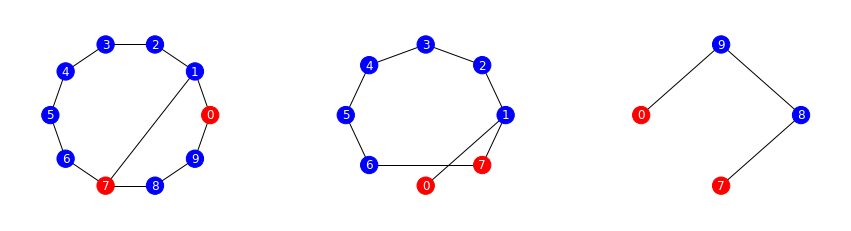

In [4]:
# 生成一个有 10 个顶点的图形
n = 10
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (1, 7),
                  (5, 6), (6, 7), (7, 8), (8, 9), (9, 0)])
    
k = 9 # 设定量子比特的最大数量
S = NaiveLGP(G,k) # 利用大图分割对图形 G 进行分割
sep_node = list(set(S[0].nodes).intersection(set(S[1].nodes))) # 找到分离顶点

# 图形示例
options = {
    "with_labels": True,
    "font_color": "white"
}
node_color1 = ["red" if i in sep_node else "blue" for i in range(n)]
node_color2 = ["red" if list(S[0].nodes)[i] in sep_node else "blue" for i in range(len(S[0].nodes))]
node_color3 = ["red" if list(S[1].nodes)[i] in sep_node else "blue" for i in range(len(S[1].nodes))]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, a in enumerate(ax):
    a.axis('off')
    a.margins(0.20)
nx.draw_networkx(G, pos=nx.circular_layout(G), ax=ax[0], **options, node_color=node_color1)
nx.draw_networkx(S[0], pos=nx.circular_layout(S[0]), ax=ax[1], **options, node_color=node_color2)
nx.draw_networkx(S[1], pos=nx.circular_layout(S[1]), ax=ax[2], **options, node_color=node_color3)

In [5]:
def GR(str_cnt1, str_cnt2):
    com_cnt = []
    n = len(str_cnt1[0][0])
    com_index = []
    for i in range(n):
        if str_cnt1[0][0][i] != "x" and str_cnt2[0][0][i] != "x":
            com_index.append(i)

    for (str1, cnt1) in str_cnt1:
        for (str2, cnt2)  in str_cnt2:           
            # 检查分离顶点在两个子图所在的集合是否一致
            validity = [str1[i] == str2[i] for i in com_index]
            if False not in validity:
                com_str = [[0]] * n
                for i in range(n):
                    if str1[i] != "x":
                        com_str[i] = str(str1[i])
                    else:
                        com_str[i] = str(str2[i])
                com_cnt.append(("".join(com_str), min(cnt1, cnt2)))

    # 将{最大割：频率}按频率从大到小排列
    com_cnt.sort(key=lambda tup:tup[1])
    return com_cnt[::-1]

In [27]:
# We use direct QAOA to compute approximate max cuts for two subgraphs
# In the next section, we will compute these using DC-QAOA because subgraphs might also exceed the qubit limit
# import paddle
# from paddle_quantum.QAOA.maxcut import find_cut
import qiskit
from qiskit.algorithms import QAOA
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize

from qiskit.visualization import plot_histogram

def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """

    tmp = 0
    mapping = {}
    for node in G.nodes():
        mapping[node] = tmp
        tmp += 1
    obj = 0

        
    for i, j in G.edges():
        if x[mapping[i]] != x[mapping[j]]:
            obj -= 1
    return obj

def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    tmp = 0
    mapping = {}
    for node in G.nodes():
        mapping[node] = tmp
        tmp += 1
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], mapping[pair[0]], mapping[pair[1]])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

# Set QAOA parameters
p = 3 # Number of layers of QAOA circuit
ITR = 100 # Iterations of the training network of QAOA
LR = 0.5 # Learning rate in the training network of QAOA
# Set graph reconstruction parameter
t = 10 # Number of partition strings kept after graph reconstruction 
# paddle.seed(999)  # Fix the seed

# Start graph reconstruction procedure
S_str_cnt = []
for si in S:
    adjacency_i = nx.adjacency_matrix(si).todense()
    siv = list(si.nodes)
    print('nodes',siv)
    n_qubits = len(siv)

    expectation = get_expectation(si, p=1)
    # print('exp_val', expectation)

    res = minimize(expectation, 
                        [1.0, 1.0], 
                        method='COBYLA')
    # print(res)
    exp_val_i = res.x
    print('result', res.x)
    qc_res = create_qaoa_circ(si, res.x)

    

    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    qc_res = create_qaoa_circ(si, res.x)

    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    # print(counts)
    counts = {k: v for k, v in sorted(counts.items(), key=lambda item: -item[1])}
    # print(counts)
    # for item in counts.items():
        # print(item)
    # plot_histogram(counts)
    # print('--------------')
    # beta = Parameter("$\\beta$")
    # qc_mix = QuantumCircuit(n_qubits)
    # qaoa_qc_i = create_qaoa_circ(si, theta)
    # Compute the subgraph's maxcut
    # tmp, si_str_cnt_relabeled = find_cut(si, p, ITR, LR)
    # print(tmp)
    # print('si_str_cnt_relabeled', si_str_cnt_relabeled)
    # Make the subgraph's maxcut match the original graph by relabeling 
    si_str_cnt = []
    for bitstring, score in counts.items():
        strr = ""
        for i in range(len(G.nodes)):
            if i in siv:
                strr += bitstring[siv.index(i)]
            else:
                strr += "x"
        si_str_cnt.append((strr, score))
    si_str_cnt.sort(key=lambda tup:tup[1])
    S_str_cnt.append(si_str_cnt[::-1][:t])

# Once we have already obtained max cut strings for two partitions, we perform the graph reconstruction (GR)
print("Max cut for the first partitioned subgraph: \n" + str(dict(S_str_cnt[0])))
print("Max cut for the second partitioned subgraph: \n" + str(dict(S_str_cnt[1])))
out_cnt = GR(S_str_cnt[0], S_str_cnt[1])
print("Combined max cut for the original graph: \n" + str(dict(out_cnt[:t])))

nodes [1, 2, 3, 4, 5, 6, 0, 7]
result [1.99093443 1.12914755]
nodes [8, 9, 0, 7]
result [1.14841032 0.5160144 ]
Max cut for the first partitioned subgraph: 
{'01101011xx': 48, '01001010xx': 40, '10010100xx': 39, '11001010xx': 36, '10110101xx': 33, '00101011xx': 28, '11001100xx': 28, '11010100xx': 27, '00110101xx': 26, '00110011xx': 25}
Max cut for the second partitioned subgraph: 
{'1xxxxxx010': 252, '0xxxxxx101': 231, '0xxxxxx011': 117, '1xxxxxx100': 111, '0xxxxxx111': 67, '1xxxxxx011': 62, '1xxxxxx000': 59, '0xxxxxx100': 51, '1xxxxxx001': 23, '0xxxxxx110': 20}
Combined max cut for the original graph: 
{'0110101100': 48, '0110101111': 48, '0110101101': 48, '0100101011': 40, '1001010000': 39, '1001010011': 39, '1001010010': 39, '1100101000': 36, '1100101011': 36, '1100101010': 36}


In [17]:
import cvxpy as cvx
import networkx as nx

def sdp_solver(G):
    """
    通过半正定规划 SDP 来找到最大割问题的理论上界。
    """
    n = len(G)
    adj_mat = nx.adjacency_matrix(G).toarray()
    Y = cvx.Variable((n, n), PSD=True)
    cut_size = 0.25 * cvx.sum(cvx.multiply(adj_mat, 1 - Y))
    problem = cvx.Problem(cvx.Maximize(cut_size), [cvx.diag(Y) == 1])
    opt_val = problem.solve(cvx.SCS)

    return opt_val

In [26]:
ubound_sdp = sdp_solver(G)
    # ubound_sdp_ls.append(ubound_sdp)
print("半正定规划找的最大割的上限: " + str(ubound_sdp))
 

半正定规划找的最大割的上限: 10.301288947057849


In [25]:
ans = "1010101010"
cut_dc_qaoa1 = ["solid" if ans[u] == ans[v] else "dashed" for (u, v) in list(G.edges)]
value_dc_qaoa = cut_dc_qaoa1.count("dashed")
print("量子近似优化分治算法找到的最大割分类: " + str(ans) + ", 最大割 = " + str(float(value_dc_qaoa))) 

量子近似优化分治算法找到的最大割分类: 1010101010, 最大割 = 10.0


In [58]:
def DC_QAOA(g, p, t, s, k, ITR, LR):
    # print(g.nodes())
    if len(g.nodes) > k:
        # 利用 大图分割 得到两个子图
        S = NaiveLGP(g, k)

        S_str_cnt = []
        for si in S:
            siv = list(si.nodes)
            # 递归性地计算子图的最大割
            _, result = DC_QAOA(si, p, t, s, k, ITR, LR)
            # print("results", result)
            # 填充子图的最大割结果，使其和母图的顶点吻合
            si_str_cnt = []
            for bitstring, score in result.items():
                # print(bitstring, score)
                # strr = ""
                # for v in G.nodes:
                #     if v in siv:
                #         strr += str_relabeled[siv.index(v)]
                #     else:
                #         strr += "x"     
                si_str_cnt.append((bitstring, score))
            # si_str_cnt.sort(key = lambda tup:tup[1])
            S_str_cnt.append(si_str_cnt)

        # 利用 图形重构 整合子图最大割
        # print("1", S_str_cnt[0])
        # print("2", S_str_cnt[1])
        out_cnt = GR(S_str_cnt[0], S_str_cnt[1])
        # print("merged", out_cnt)
    else:
        if len(g.nodes) == 1:
            return [("0", 99999), ("1", 99999)]
        
        siv = list(g.nodes)
        # print('nodes',siv)
        n_qubits = len(siv)

        expectation = get_expectation(g, p=1)
        # print('exp_val', expectation)

        res = minimize(expectation, 
                            [1.0, 1.0], 
                            method='COBYLA')
        # print(res)
        exp_val_i = res.x
        # print('result', res.x)
        qc_res = create_qaoa_circ(g, res.x)

    

        backend = Aer.get_backend('aer_simulator')
        backend.shots = 512

        qc_res = create_qaoa_circ(g, res.x)

        counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
        # print(counts)
        counts = {k: v for k, v in sorted(counts.items(), key=lambda item: -item[1])}

        si_str_cnt = []
        for bitstring, score in counts.items():
            strr = ""
            for i in range(len(G.nodes)):
                if i in siv:
                    strr += bitstring[siv.index(i)]
                else:
                    strr += "x"
            si_str_cnt.append((strr, score))
            
        # 将词典格式转成列表格式，易于排序
        out_cnt = si_str_cnt
        # 将{最大割：频率}按频率从大到小排列
        out_cnt.sort(key=lambda tup:tup[1])
        out_cnt = out_cnt[::-1]

    # 只保留最有可能的t个最大割
    out_cnt = out_cnt[:t]
    # print(out_cnt)
    # 等比例调节频率的显示
    cnt_sum = sum(cnt for (str,cnt) in out_cnt)
    out_cnt = [(k, int(s * v / cnt_sum)) for (k, v) in out_cnt]

    return out_cnt[0][0], dict(out_cnt)

# 设定 量子近似优化算法 中的参数
p = 2     # 量子电路的层数
ITR = 100 # 训练迭代的次数
LR = 0.5  # 基于梯度下降的优化方法的学习率

# 设定 量子近似优化分治算法 中的参数
s = 3000  # 等比例调节频率的比例
t = 10    # 想要保留最有可能的最大割的数量
k = 5     # 量子比特的数量限制

# 量子近似优化分治算法使用
max_cut, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
print("最有可能的 t 个图形 G 的最大割: " + str(out_cnt))
print("量子近似优化分治算法找到的图形 G 的（最有可能的）最大割: " + str(max_cut))

最有可能的 t 个图形 G 的最大割: {'1000101111': 356, '0111010100': 345, '1000101011': 322, '0111010000': 320, '0100110010': 289, '0100110110': 289, '0111011000': 268, '0111011100': 268, '1000100011': 268, '1000100111': 268}
量子近似优化分治算法找到的图形 G 的（最有可能的）最大割: 1000101111


In [56]:


G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 4), (1, 2), (1, 4), (2, 4), (3, 4)])
k = 3
_, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
print("最有可能的 t 个图形 G 的最大割：" + str(dict(out_cnt)))



results {'1xxx0': 1552, '0xxx1': 1447}
results {'x11x0': 521, 'x10x0': 518, 'x01x0': 512, 'x10x1': 512, 'x01x1': 468, 'x00x1': 465}
1 [('1xxx0', 1552), ('0xxx1', 1447)]
2 [('x11x0', 521), ('x10x0', 518), ('x01x0', 512), ('x10x1', 512), ('x01x1', 468), ('x00x1', 465)]
merged [('111x0', 521), ('110x0', 518), ('010x1', 512), ('101x0', 512), ('001x1', 468), ('000x1', 465)]
results {'111x0': 521, '110x0': 518, '010x1': 512, '101x0': 512, '001x1': 468, '000x1': 465}
results {'0xx10': 846, '1xx01': 779, '1xx10': 380, '0xx01': 322, '1xx00': 295, '0xx11': 292, '0xx00': 49, '1xx11': 32}
1 [('111x0', 521), ('110x0', 518), ('010x1', 512), ('101x0', 512), ('001x1', 468), ('000x1', 465)]
2 [('0xx10', 846), ('1xx01', 779), ('1xx10', 380), ('0xx01', 322), ('1xx00', 295), ('0xx11', 292), ('0xx00', 49), ('1xx11', 32)]
merged [('10110', 380), ('11010', 380), ('11110', 380), ('00001', 322), ('00101', 322), ('01001', 322), ('10100', 295), ('11000', 295), ('11100', 295), ('00011', 292), ('00111', 292), ('01

In [81]:
n = 20
iter = 5
print("顶点数量 = " + str(n))
print("顶点编号 = " + str([i for i in range(n)]))

value_dc_qaoa_ls = []
ubound_sdp_ls = []
for i in range(iter):
    print("\n随机图形 " + str(i+1))
    # 生成随机图形
    G = nx.erdos_renyi_graph(n, 0.2, 100 * i, directed=False)
    while nx.is_connected(G) == False:
        G = nx.erdos_renyi_graph(n, 0.2, directed=False)
    print("边 = " + str(list(G.edges)))
    
    # 半正定规划（SDP）方法找最大割的上限
    ubound_sdp = sdp_solver(G)
    ubound_sdp_ls.append(ubound_sdp)
    print("半正定规划找的最大割的上限: " + str(ubound_sdp))


    # 设定 量子近似优化算法 中的参数
    p = 3      # 量子电路的层数
    ITR = 100  # 训练迭代的次数
    LR = 0.5   # 基于梯度下降的优化方法的学习率
    # 设定 量子近似优化分治算法 中的参数
    s = 3000   # 等比例调节频率的比例
    t = 10     # 想要保留最有可能的最大割的数量
    k = 5      # 量子比特的数量限制

    try:
        cut_dc_qaoa, out_cnt = DC_QAOA(G, p, t, s, k, ITR, LR)
        cut_dc_qaoa1 = ["solid" if cut_dc_qaoa[u] == cut_dc_qaoa[v] else "dashed" for (u, v) in list(G.edges)]
        value_dc_qaoa = cut_dc_qaoa1.count("dashed")
        value_dc_qaoa_ls.append(value_dc_qaoa)
        print("量子近似优化分治算法找到的最大割分类: " + str(cut_dc_qaoa) + ", 最大割 = " + str(float(value_dc_qaoa))) 
    except Exception as e:
        value_dc_qaoa = 0
        value_dc_qaoa_ls.append(value_dc_qaoa)
        print("量子近似优化分治算法找最大割失败，错误信息：'" + str(e) + "'")

顶点数量 = 20
顶点编号 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

随机图形 1
边 = [(0, 2), (0, 9), (0, 12), (0, 13), (0, 14), (1, 4), (2, 5), (2, 10), (2, 16), (3, 7), (3, 8), (3, 10), (3, 11), (3, 13), (3, 15), (3, 19), (4, 5), (4, 15), (4, 16), (5, 7), (5, 9), (5, 13), (6, 10), (6, 13), (6, 16), (6, 17), (6, 18), (7, 12), (7, 13), (7, 18), (7, 19), (8, 17), (9, 10), (9, 12), (9, 18), (10, 11), (10, 15), (10, 16), (10, 18), (11, 12), (12, 19), (13, 14), (15, 18), (16, 17)]
半正定规划找的最大割的上限: 35.53446878271906
量子近似优化分治算法找到的最大割分类: 00101111110110111001, 最大割 = 27.0

随机图形 2
边 = [(0, 1), (0, 9), (0, 11), (0, 18), (0, 19), (1, 10), (1, 12), (1, 13), (1, 17), (2, 7), (3, 17), (4, 5), (4, 8), (4, 9), (4, 18), (4, 19), (5, 6), (5, 19), (6, 9), (6, 10), (6, 12), (6, 13), (6, 15), (6, 16), (7, 11), (7, 14), (8, 12), (9, 12), (9, 13), (10, 14), (10, 16), (11, 12), (11, 14), (11, 18), (12, 15), (13, 15), (13, 18), (15, 18), (15, 19), (16, 18), (16, 19), (17, 18), (17, 19)]
半正定规划找的最大割的